In [1]:
import pathlib

import laspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import skimage
import src.datasets

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
%aimport src.clouds
%aimport src.datasets
%aimport src.visualization.clouds

In [4]:
data_dir = pathlib.Path("../../data").resolve()

data_paths = {
    "lysva-raw": data_dir / "raw" / "lysva",
    "lysva-interim": data_dir / "interim" / "lysva",
    "trees": data_dir / "raw" / "trees",
}

lysva_als_files = sorted((data_paths["lysva-interim"] / "als").glob("*.las"))

In [5]:
dataset_20 = src.datasets.SyntheticForestRGBMBFPatch(
    root="../../data/interim/synthetic_forest/",
    patch_width=20,
    patch_height=20,
    patch_overlap=0.75,
    force_reload=True,
    random_seed=69,
    intensity=True,
    edges=True,
    texture=True,
    sigma_min=1,
    sigma_max=1,
)

Processing...
Done!


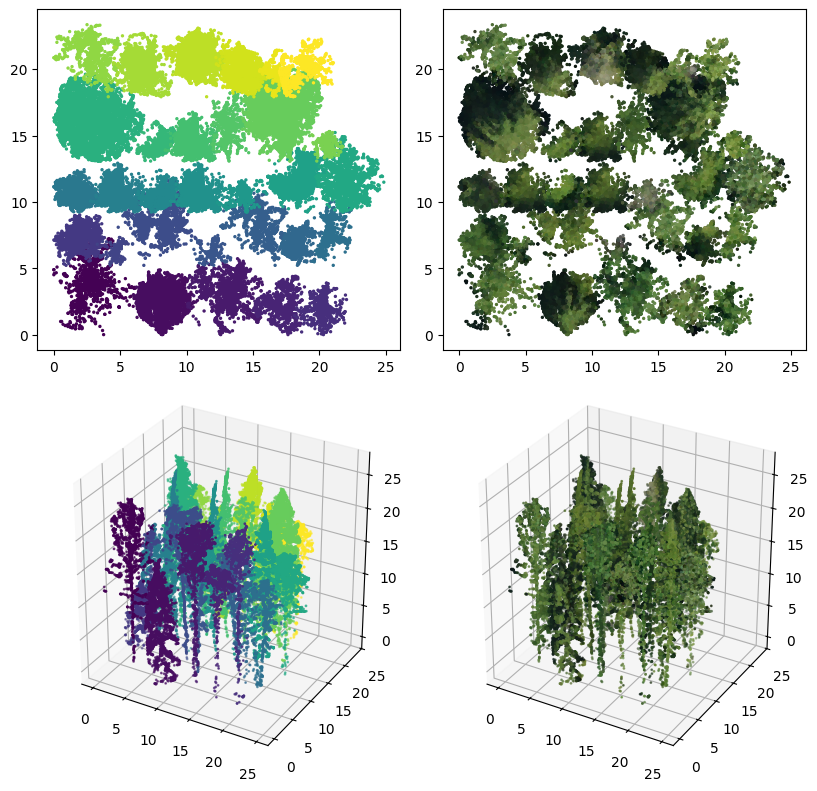

In [6]:
#| include: true
#| label: fig-synthetic-forest-patch-example
#| fig-cap: |
#|   A visualisation of a synthetic forest patch used for training the tree segmentation
#|   network. Top:
#| fig-scap: Visualisation of a synthetic forest patch used for training

example = dataset_20[2]
label = example.y.numpy()
rgb = example.x[:, 0:3].numpy() / 255

fig = plt.figure(figsize=(8.27, 8.27), tight_layout=True)

ax = src.visualization.clouds.scatter_point_cloud_2d(
    xyz=example.pos.numpy(),
    projection="XY",
    sort_by_height=True,
    color=label,
    ax=fig.add_subplot(221),
)

ax = src.visualization.clouds.scatter_point_cloud_2d(
    xyz=example.pos.numpy(),
    projection="XY",
    sort_by_height=True,
    color=rgb,
    ax=fig.add_subplot(222),
)

ax = src.visualization.clouds.scatter_point_cloud_3d(
    xyz=example.pos.numpy(),
    color=label,
    ax=fig.add_subplot(223, projection="3d"),
)

ax = src.visualization.clouds.scatter_point_cloud_3d(
    xyz=example.pos.numpy(),
    color=rgb,
    ax=fig.add_subplot(224, projection="3d"),
)

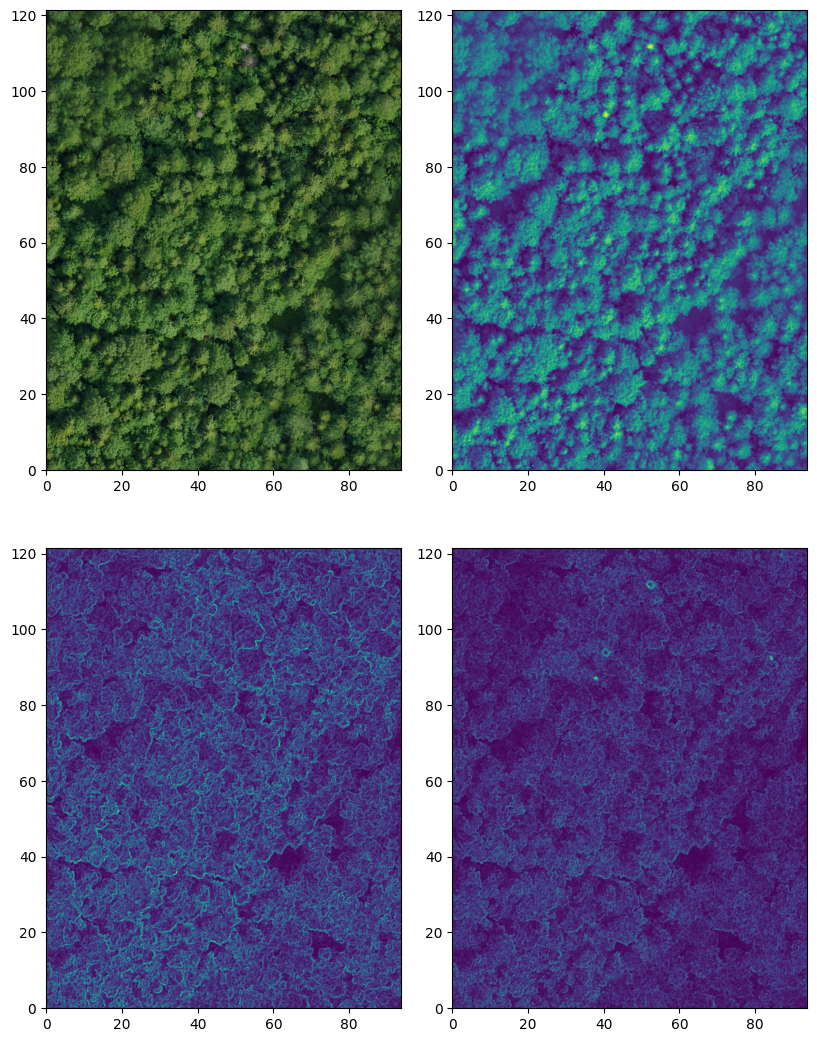

In [7]:
#| include: true
#| label: fig-basic-features-small
#| fig-cap: |
#|   A visualisation of the basic orthophoto-based features used (on a single scale with sigma=1)
#|   **Top left**: The original orthophoto for plot 10.
#|   **Top right**: Intensity feature.
#|   **Bottom left**: Edges feature.
#|   **Bottom right**: Texture feature.
#| fig-scap: Visualisation of a basic orthophoto-based features (small scale)

with rasterio.open("../../data/raw/lysva/ortho/plot_10.tif") as dd:
    ortho = dd.read()
    multiscale_features = skimage.feature.multiscale_basic_features(
        image=ortho,
        channel_axis=0,
        intensity=True,
        edges=True,
        texture=True,
        sigma_min=1,
        sigma_max=1,
        num_sigma=None,
    )

fig, axes = plt.subplots(2, 2, figsize=(8.27, 11.69), tight_layout=True)

params = {"extent": (0, dd.res[0] * dd.width, 0, dd.res[1] * dd.height)}

ax = axes[0, 0].imshow(np.rollaxis(ortho, 0, 3), **params)
axes[0, 1].imshow(multiscale_features[..., 0], **params)
axes[1, 0].imshow(multiscale_features[..., 5], **params)
axes[1, 1].imshow(multiscale_features[..., 9], **params);

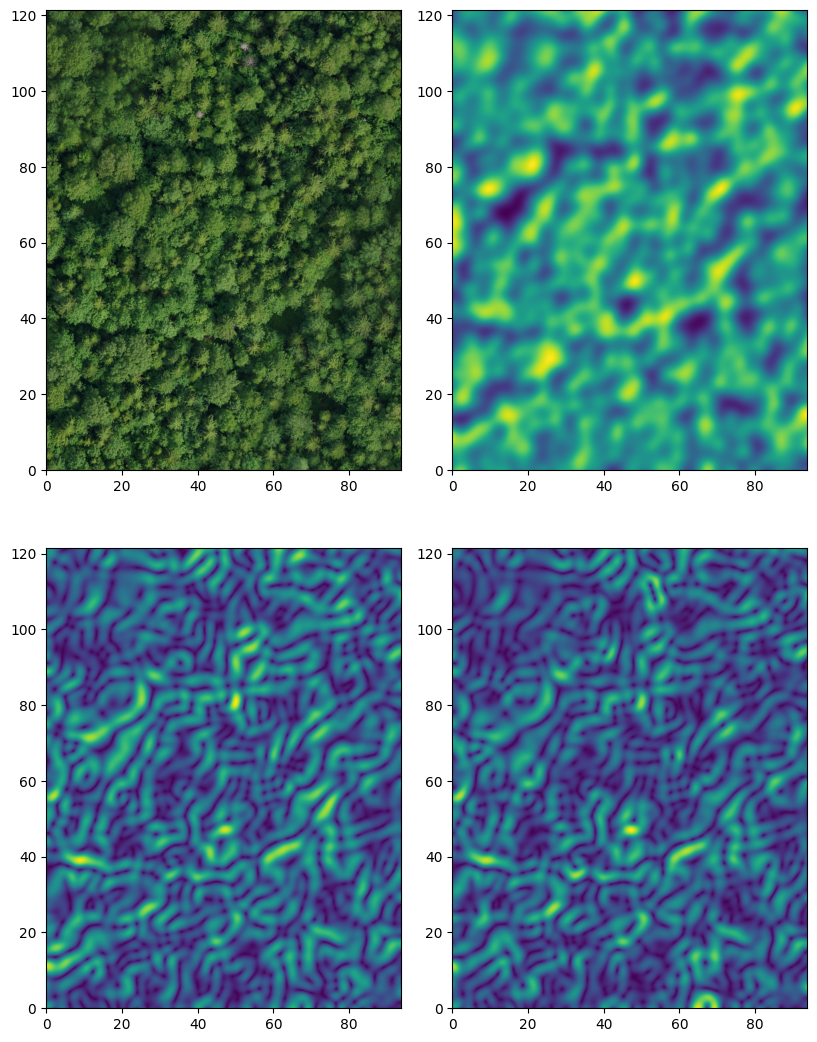

In [8]:
#| include: true
#| label: fig-basic-features-large
#| fig-cap: |
#|   A visualisation of the basic orthophoto-based features used (on a single scale with sigma=16)
#|   **Top left**: The original orthophoto for plot 10.
#|   **Top right**: Intensity feature.
#|   **Bottom left**: Edges feature.
#|   **Bottom right**: Texture feature.
#| fig-scap: Visualisation of a basic orthophoto-based features (large scale)

with rasterio.open("../../data/raw/lysva/ortho/plot_10.tif") as dd:
    ortho = dd.read()
    multiscale_features = skimage.feature.multiscale_basic_features(
        image=ortho,
        channel_axis=0,
        intensity=True,
        edges=True,
        texture=True,
        sigma_min=16,
        sigma_max=16,
        num_sigma=None,
    )

fig, axes = plt.subplots(2, 2, figsize=(8.27, 11.69), tight_layout=True)

params = {"extent": (0, dd.res[0] * dd.width, 0, dd.res[1] * dd.height)}

ax = axes[0, 0].imshow(np.rollaxis(ortho, 0, 3), **params)
axes[0, 1].imshow(multiscale_features[..., 0], **params)
axes[1, 0].imshow(multiscale_features[..., 5], **params)
axes[1, 1].imshow(multiscale_features[..., 9], **params);

In [9]:
#| include: true
#| label: fig-synthetic-forest-patch-example-2
#| fig-cap: |
#|   A visualisation of a synthetic forest patch used for training the tree segmentation
#|   network. Top:
#| fig-scap: Visualisation of a synthetic forest patch used for training

# i = 0

# example = dataset_20[2]
# label = example.y.numpy()
# rgb = example.x[:, 0:3].numpy() / 255

# fig = plt.figure(figsize=(8.27, 8.27), tight_layout=True)

# ax = src.visualization.clouds.scatter_point_cloud_2d(
#     xyz=example.pos.numpy(),
#     projection="XY",
#     sort_by_height=True,
#     color=label,
#     ax=fig.add_subplot(221),
# )

# ax = src.visualization.clouds.scatter_point_cloud_2d(
#     xyz=example.pos.numpy(),
#     projection="XY",
#     sort_by_height=True,
#     color=rgb,
#     ax=fig.add_subplot(222),
# )

# ax = src.visualization.clouds.scatter_point_cloud_3d(
#     xyz=example.pos.numpy(),
#     color=label,
#     ax=fig.add_subplot(223, projection="3d"),
# )

# ax = src.visualization.clouds.scatter_point_cloud_3d(
#     xyz=example.pos.numpy(),
#     color=rgb,
#     ax=fig.add_subplot(224, projection="3d"),
# )

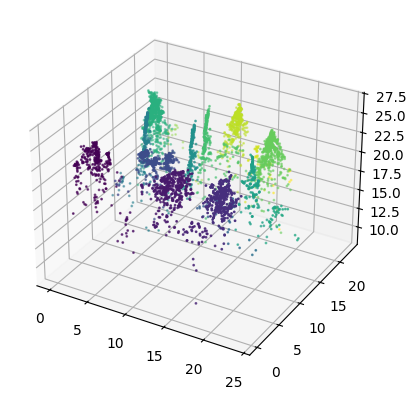

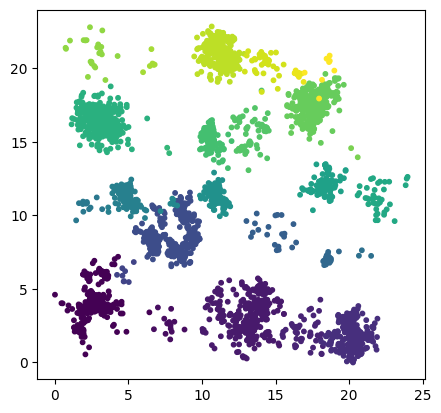

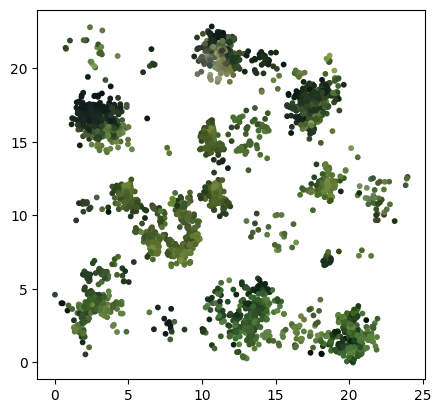

In [10]:
xyz, label, rgb = src.clouds.dropout_low_points_sigmoid(
    example.pos.numpy(),
    example.y.numpy(),
    example.x[:, 0:3].numpy() / 255,
    scale=16,
    shift=2.2,
)
ax = src.visualization.clouds.scatter_point_cloud_3d(
    xyz=xyz,
    color=label,
)
ax = src.visualization.clouds.scatter_point_cloud_2d(
    xyz=xyz,
    projection="XY",
    s=10,
    color=label,
)
ax = src.visualization.clouds.scatter_point_cloud_2d(
    xyz=xyz,
    projection="XY",
    s=10,
    color=rgb,
)

In [11]:
las = laspy.read(lysva_als_files[0])
xyz = las.xyz
color = np.stack([las.red, las.green, las.blue], axis=1) / 255

height_mask = xyz[:, 2] >= 2
xyz, color = xyz[height_mask], color[height_mask]
xyz = src.clouds.recenter_cloud(xyz)

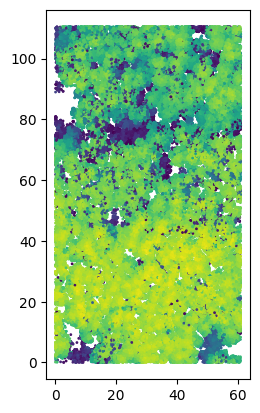

In [12]:
ax = src.visualization.clouds.scatter_point_cloud_2d(
    xyz,
    projection="XY",
    s=1,
)

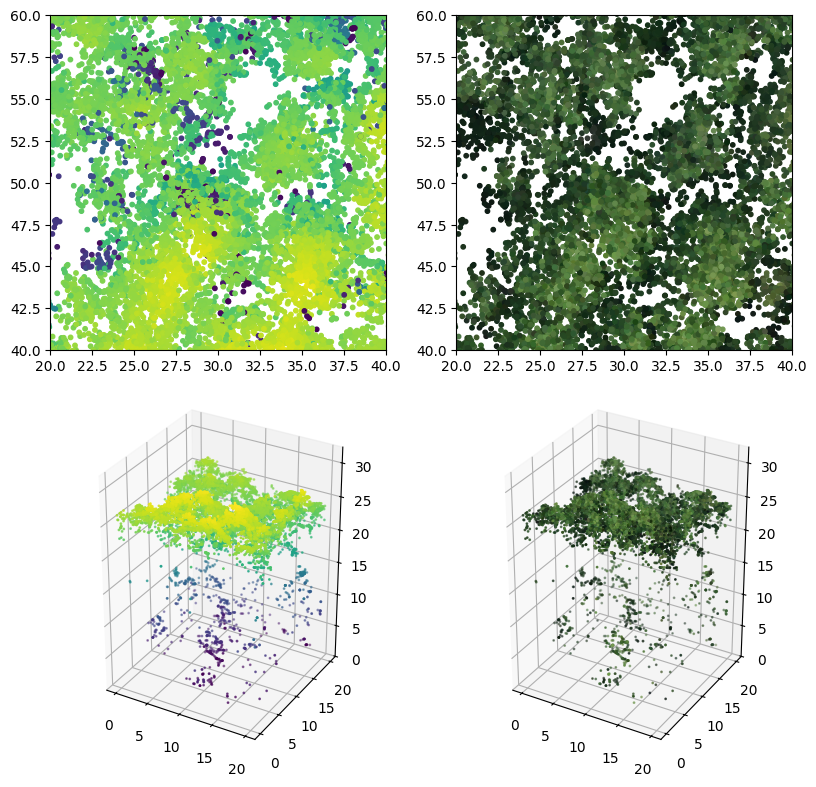

In [13]:
#| include: true
#| label: fig-lysva-plot-window-example
#| fig-cap: |
#|   A visualisation of a synthetic forest patch used for training the tree segmentation
#|   network. Top:
#| fig-scap: Visualisation of a synthetic forest patch used for training

origin = (20, 40)
window = (20, 20)

window_mask = (
    (xyz[:, 0] >= origin[0])
    & (xyz[:, 0] < origin[0] + window[0])
    & (xyz[:, 1] >= origin[1])
    & (xyz[:, 1] < origin[1] + window[1])
)

fig = plt.figure(figsize=(8.27, 8.27), tight_layout=True)

ax0 = src.visualization.clouds.scatter_point_cloud_2d(
    xyz=xyz,
    projection="XY",
    sort_by_height=True,
    ax=fig.add_subplot(221),
    s=10,
)

ax1 = src.visualization.clouds.scatter_point_cloud_2d(
    xyz=xyz,
    projection="XY",
    sort_by_height=True,
    color=color,
    ax=fig.add_subplot(222),
    s=10,
)

ax2 = src.visualization.clouds.scatter_point_cloud_3d(
    xyz=xyz[window_mask],
    ax=fig.add_subplot(223, projection="3d"),
)

ax3 = src.visualization.clouds.scatter_point_cloud_3d(
    xyz=xyz[window_mask],
    color=color[window_mask],
    ax=fig.add_subplot(224, projection="3d"),
)

for ax in (ax0, ax1):
    ax.set_xlim(origin[0], origin[0] + window[0])
    ax.set_ylim(origin[1], origin[1] + window[1])